# Bayesian Repertoire Overlap

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from scipy.stats import hypergeom
from scipy.stats import binned_statistic as binsta
from scipy.special import logsumexp
from util import *
import palettable as pal
clr = pal.cartocolors.qualitative.Prism_10.mpl_colors
clr = tuple(x for n,x in enumerate(clr) if n in [1,2,4,5,6])
clr2 = pal.cartocolors.sequential.agSunset_7.mpl_colors

## Simulation

In [2]:
# CCP, the Coupon Collector's Problem
def ccp_sample(c,pool=40):
    return len(set(np.random.choice(pool,c)))

In [3]:
# Draw overlap
def nab_sample(s,na,nb,pool=40):
    sa = np.random.hypergeometric(s,pool-s,na)
    nab = np.random.hypergeometric(sa,pool-sa,nb)
    return nab

In [4]:
# Overlap between two PCRs of depth c and overlap s
def pcr_sample(c,s):
    na = ccp_sample(c)
    nb = ccp_sample(c)
    return nab_sample(s,na,nb),na,nb

## Theory

In [5]:
def p_ccp(c, pool=40):
    p = np.zeros([c+1,pool+1])
    p[0,0] = 1;
    for row in range(1,c+1):
        for k in range(1,np.min([row+2,pool+1])):
            p[row,k] = p[row-1,k]*k/pool + p[row-1,k-1]*(1-(k-1)/pool)
    return p[-1,:]

In [6]:
def p_overlap(na,nb,nab,pool=40):
    p_s = np.zeros(pool+1)
    # reference: hypergeom.pmf(outcome, Total, hits, Draws, loc=0)
    for s in np.arange(pool+1):
        # p_sa is the probabiltiy that we'd get sa from the overlap (s), just in na draws of a
        p_sa = hypergeom.pmf(np.arange(pool+1),pool,s,na)
        # p_nab_given_sa is the probability of getting that nab, given sa
        p_nab_given_sa = hypergeom.pmf(nab,pool,np.arange(pool+1),nb)
        p_s[s] = np.dot(p_sa,p_nab_given_sa)
    return p_s/np.sum(p_s)

def e_overlap(na,nb,nab,pool=40):
    p_s = p_overlap(na,nb,nab,pool=pool)
    return np.dot(np.arange(pool+1),p_s)

In [7]:
def credible_interval(na,nb,nab,pool=40):
    p_s = p_overlap(na,nb,nab,pool=pool)
    cdf = np.cumsum(p_s)
    try:
        lower = np.where(cdf <= 0.05)[0][-1]
    except IndexError:
        lower = 0
    try:
        upper = np.where((1-cdf) <= 0.05)[0][0]
    except IndexError:
        upper=pool
    expectation = np.dot(np.arange(pool+1),p_s)
    return lower,expectation,upper

In [8]:
def p_nab_given_c(s,c,pool=40):
    pna = p_ccp(c)
    pnb = p_ccp(c)
    nas = np.arange(1,len(pna))
    nbs = np.arange(1,len(pnb))
    p_gen = np.zeros([pool+1,pool+1,pool+1])
    for na in nas:
        p_sa = hypergeom.pmf(np.arange(pool+1),pool,s,na)
        for nb in nbs:
            pna_pnb = pna[na] * pnb[nb]
            for nab in range(0,np.minimum(na,nb)):
                p_nab_given_sa = hypergeom.pmf(nab,pool,np.arange(pool+1),nb)
                p_nab_given_s = np.dot(p_sa,p_nab_given_sa)
                p_gen[na,nb,nab] = p_nab_given_s * pna_pnb
    return p_gen

In [9]:
def p_shat_given_sc(s,c,shat,pool=40):
    masses = p_nab_given_c(s,c,pool=pool)
    if np.sum(masses)<0.99:
        print('Swapping to Monte Carlo')
        return p_shat_given_sc_montecarlo(s,c,shat,pool=pool)
    hist = binsta(np.ravel(shat),np.ravel(masses),statistic='sum',bins=(np.arange(pool+2)-0.5))
    return hist

In [10]:
def p_shat_given_sc_montecarlo(s,c,shat,pool=40,n_mc=int(1e5)):
    masses = np.zeros([pool+1,pool+1,pool+1])
    for ii in range(n_mc):
        nab,na,nb = pcr_sample(c,s)
        masses[na,nb,nab] += 1
    hist = binsta(np.ravel(shat),np.ravel(masses/n_mc),statistic='sum',bins=(np.arange(pool+2)-0.5))
    return hist

In [11]:
def compute_all_estimates(pool=40):
    shat = np.zeros([pool+1,pool+1,pool+1])
    for na in range(1,pool+1):
        for nb in range(1,pool+1):
            for nab in range(0,np.minimum(na+1,nb+1)):
                shat[na,nb,nab] = e_overlap(na,nb,nab,pool=pool)
    return shat

In [14]:
# shat = compute_all_estimates(pool=40)
# np.save('shat_40.npy',shat)
shat = np.load('shat_40.npy')

In [17]:
np.shape(shat)

(41, 41, 41)

In [ ]:
numpy.savetxt('shat_40.csv', shat, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)[source]

## Manuscript calculations

Suppose that $s=20$ sequences are shared between two repertoires, and that the repertoires are sampled at rates $n_a=21$ and $n_b=16$.  What is the distribution of PTS estimates?

In [34]:
nabs = np.zeros(1000)
for ii in range(1000):
    nabs[ii] = nab_sample(s=20,na=21,nb=16,pool=40)
pts = 2*nabs/(21+16)
print("Mean PTS is {:.2f} when it should be 0.5.".format(np.mean(pts)))

Mean PTS is 0.23 when it should be 0.5.


## Tests

### Test 0: Show a posterior

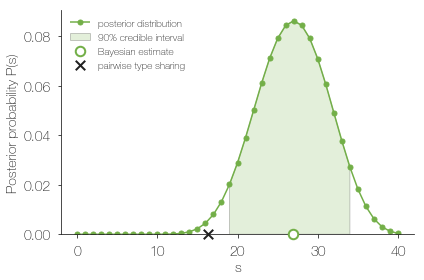

In [13]:
na = 27
nb = 22
nab = 10
pool = 40
pts = pool*2*nab/(na+nb)
ps = p_overlap(na,nb,nab,pool=pool)
lower,shat,upper = credible_interval(na,nb,nab,pool=pool)
x = np.arange(lower,upper+1)
y = np.copy(ps[x])
x = np.append(x,upper)
y = np.append(y,0)
x = np.insert(x,0,lower)
y =np.insert(y,0,0)
er =np.zeros([2,1])
er[0] = shat-lower
er[1] = upper-shat

fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(np.arange(41),ps,
        label='posterior distribution',
        linestyle='-',
        marker='o',
        ms=5,
        color = clr[2])

ax.scatter(shat,0,
           facecolor=[1,1,1],
           edgecolor=clr[2],
           linewidth = 2,
                s=90,
           marker='o',
           label='Bayesian estimate',
          clip_on=False,zorder=100)

ax.fill(x,y,
        facecolor=clr[2],
        edgecolor=[0,0,0],
        alpha=0.2,
        label='90% credible interval',)

ax.scatter(pts,0,
        linewidth=2,
        color=ALMOST_BLACK_V,
        marker='x',
                s=90,
        label='pairwise type sharing',
       clip_on=False,zorder=100)

ax.set_ylim(bottom=0)
ax.legend()
plt.ylabel('Posterior probability P(s)')
plt.xlabel('s')
finalize(ax)
plt.tight_layout()
plt.savefig('figures/posterior_example.pdf')
# plt.show()

### Test 1: recovery accuracy as sampling increases

In [15]:
pool=40

In [43]:
reps=4
recovered = np.zeros([6,reps,pool+1])
planted = np.zeros([6,reps,pool+1])
recovered_pts = np.zeros([6,reps,pool+1])
nas = [20,25,30,35,40]
for idxa,na in enumerate(nas):
    nb = na
    for s in np.arange(0,pool+1,1):
        for rep in range(3):
            nab = nab_sample(s,na,nb)
            planted[idxa,rep,s] = s
            recovered[idxa,rep,s] = e_overlap(na,nb,nab)
            recovered_pts[idxa,rep,s] = 2*nab/(na+nb)

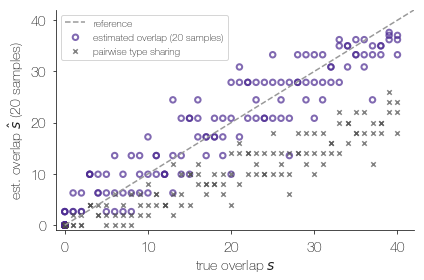

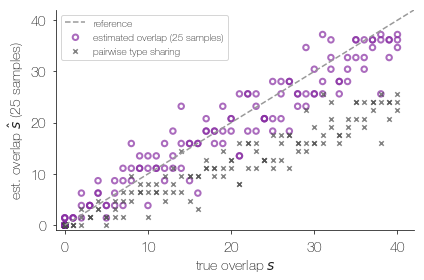

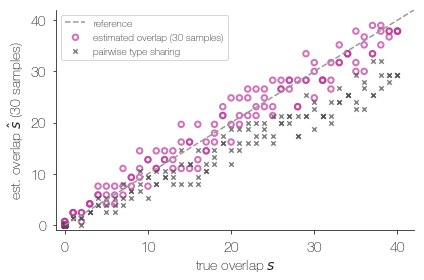

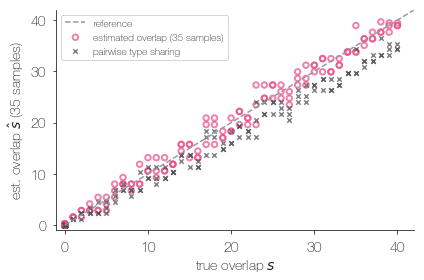

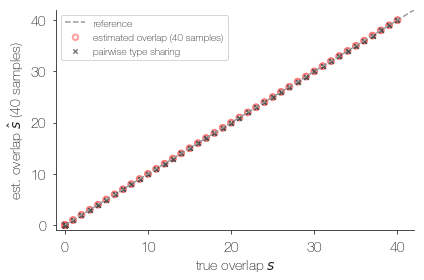

In [63]:
for idxa,na in enumerate(nas):
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    ax.plot([0,60],[0,60],color=[0.6,0.6,0.6],
            label='reference',
            linestyle='--')
    ax.scatter(planted[idxa,:,:],recovered[idxa,:,:],
               label='estimated overlap ({} samples)'.format(na),
               edgecolor = clr2[idxa],
               facecolor = 'none',
               linewidth = 2,
               s = 30,
               alpha = 0.7,
              )
    ax.scatter(planted[idxa,:,:],pool*recovered_pts[idxa,:,:],
               label='pairwise type sharing',
               c = [0.3,0.3,0.3],
               marker = 'x',
               s = 20,
               alpha = 0.7,
              )
    ax.axis([-1, pool+2, -1, pool+2])
    ax.legend()
    plt.ylabel('est. overlap $\hat s$ ({} samples)'.format(na))
    plt.xlabel('true overlap $s$')
    finalize(ax)
    plt.tight_layout()
    plt.savefig('figures/bayes_pts_{}.pdf'.format(na))
    plt.show()

### Test 2: Credible Intervals

In [14]:
pool=40
planted2 = np.zeros([6,6,pool+1])
recovered2 = np.zeros([6,6,pool+1])
lower = np.zeros([6,6,pool+1])
upper = np.zeros([6,6,pool+1])

nas = [20,25,30,35,40]
for idxa,na in enumerate(nas):
    nb = na
    idxb = idxa
    for s in np.arange(0,pool+1,1):
        planted2[idxa,idxb,s] = s
        nab = nab_sample(s,na,nb)
        lower[idxa,idxb,s], recovered2[idxa,idxb,s], upper[idxa,idxb,s] = credible_interval(na,nb,nab)
        es = e_overlap(na,nb,nab)
        recovered2[idxa,idxb,s] = es

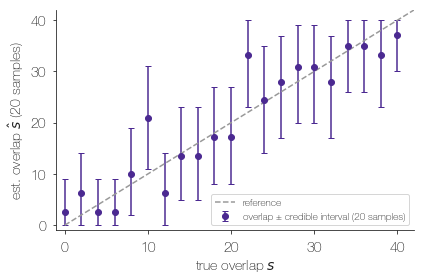

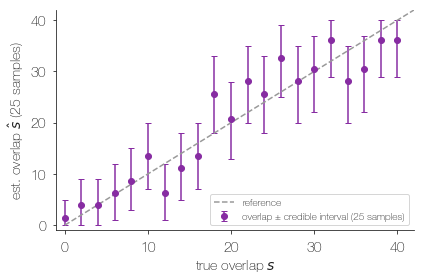

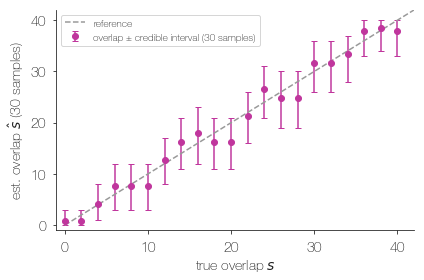

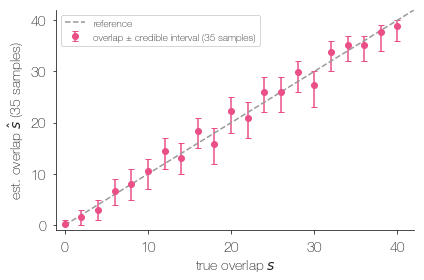

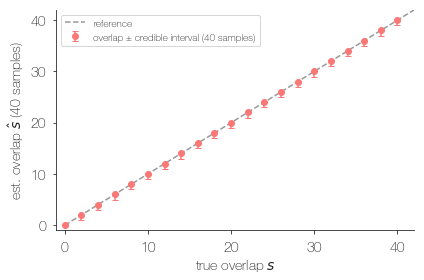

In [18]:
sub = np.arange(0,pool+1,2)
for idxa,na in enumerate(nas):
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    ax.errorbar(planted2[idxa,idxa,sub],recovered2[idxa,idxa,sub],
               yerr = [recovered2[idxa,idxa,sub]-lower[idxa,idxa,sub],upper[idxa,idxa,sub]-recovered2[idxa,idxa,sub]],  
               label='overlap ± credible interval ({} samples)'.format(na),
               c = clr2[idxa],
                capsize=3,
                fmt='o',
              )
    ax.plot([0,60],[0,60],color=[0.6,0.6,0.6],
            label='reference',
            linestyle='--')
    ax.axis([-1, pool+2, -1, pool+2])
    ax.legend()
    plt.ylabel('est. overlap $\hat s$ ({} samples)'.format(na))
    plt.xlabel('true overlap $s$')
    finalize(ax)
    plt.tight_layout()
    plt.savefig('figures/cred_reg_{}.pdf'.format(na))
    plt.show()

### Test 3: Distribution of errors from PCR

In [40]:
hist_error = {}
pool = 40
ss = [5,15,25,35,40]
cc = [48,96]
# ss=[40]
# cc=[160]

In [41]:
for c in cc:
    hist_error[c] = np.zeros([len(ss),pool+1])
    for idx,s in enumerate(ss):
        hist_error[c][idx,:] = np.array(p_shat_given_sc(s,c,shat)[0])

Swapping to Monte Carlo


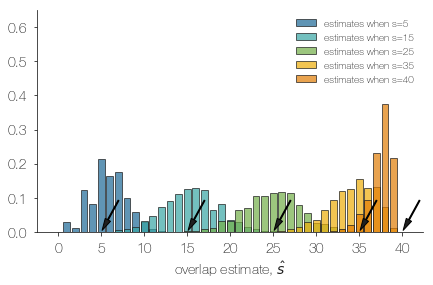

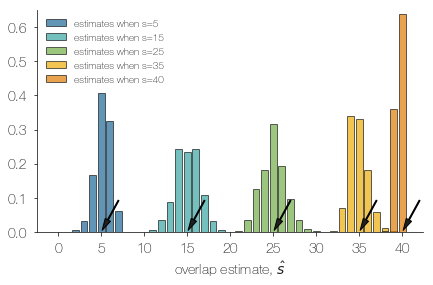

In [43]:
for c in cc:
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    for idx,s in enumerate(ss):
        ax.bar(np.arange(pool+1),hist_error[c][idx],
              color = clr[idx],
               label='estimates when s={}'.format(s),
               alpha=0.7,
               ec = ALMOST_BLACK_V
              )
        plt.xlabel('overlap estimate, $\hat{s}$')
        ax.set_ylim(top=0.65)
        scx = ax.get_xlim()[1]
        scy = ax.get_ylim()[1]
    for idx,s in enumerate(ss):
        ax.annotate("", xy=(s, 0), xytext=(s+0.05*scx, 0.15*scy),
            arrowprops=dict(
            facecolor=ALMOST_BLACK_V,
                width=1,
            headwidth=6,
            shrink=0.05))
    plt.tight_layout()
    plt.legend()
    finalize(ax)
    plt.savefig('figures/s_hat_PCR_c{}.pdf'.format(c))
    plt.show()

# Distributions of errors from PCR vs c

In [19]:
hist_error_2 = {}
ss = [25]
pool = 40
cc = [48,96,144,192]

In [20]:
for c in cc:
    hist_error_2[c] = np.zeros([len(ss),pool+1])
    for idx,s in enumerate(ss):
        hist_error_2[c][idx,:] = np.array(p_shat_given_sc(s,c,shat)[0])

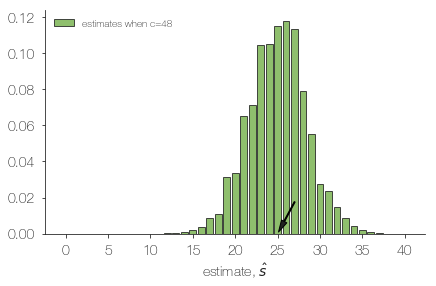

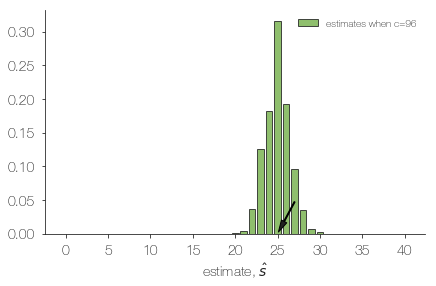

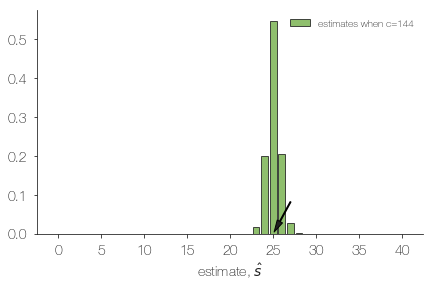

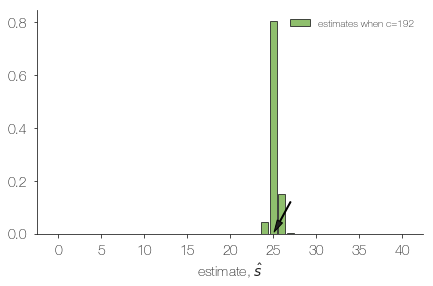

In [21]:
for c in cc:
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    for idx,s in enumerate(ss):
        ax.bar(np.arange(pool+1),hist_error_2[c][idx],
              color = clr[2],
               label='estimates when c={}'.format(c),
               alpha = 0.8,
               ec = ALMOST_BLACK_V
              )
        plt.xlabel('estimate, $\hat{s}$')
        scx = ax.get_xlim()[1]
        scy = ax.get_ylim()[1]
    for idx,s in enumerate(ss):
        ax.annotate("", xy=(s, 0), xytext=(s+0.05*scx, 0.15*scy),
            arrowprops=dict(
            facecolor=ALMOST_BLACK_V,
                width=1,
            headwidth=6,
            shrink=0.05))
    plt.tight_layout()
    finalize(ax)
    plt.savefig('figures/s_hat_PCR_s{}_c{}.pdf'.format(s,c))
    plt.show()

# Bits


In [26]:
def logp_nab_given_c(s,c,pool=40):
    pna = np.log(p_ccp(c))
    pnb = np.log(p_ccp(c))
    nas = np.arange(1,len(pna))
    nbs = np.arange(1,len(pnb))
    logp_gen = np.full((pool+1,pool+1,pool+1), -np.inf)
    for na in nas:
        logp_sa = hypergeom.logpmf(np.arange(pool+1),pool,s,na)
        for nb in nbs:
            logpna_pnb = pna[na] + pnb[nb] # + for log
            for nab in range(0,np.minimum(na,nb)):
                logp_nab_given_sa = hypergeom.logpmf(nab,pool,np.arange(pool+1),nb)
                logp_nab_given_s = logsumexp(logp_nab_given_sa + logp_sa)
#                 logp_nab_given_s = np.log(np.dot(p_sa,p_nab_given_sa))
                logp_gen[na,nb,nab] = logp_nab_given_s + logpna_pnb # + for log
    return logp_gen